In [29]:
import os
from numba import njit
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy.integrate import odeint

print(f"Running on PyMC v{pm.__version__}")
plt.rcParams['text.usetex'] = True

Running on PyMC v5.10.4


In [4]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [8]:
# SET THE WORKING DIRECTORY
CWD = '/Users/miguel/Documents/Internship_CENTURI'
os.chdir(CWD)
## DEFINES WORKING CONSTANTS
#FILENAME = args.filename
FILENAME = 'plate_counts.csv'
SAVE_FN = FILENAME.strip().split('.')[0]


In [83]:
class EvolutionExperiment():
    '''
    Takes as input:
        name: name of the model
        t: time array
        params: dictionary with 5 parameters, the replication rates(r_f,r_c), transition rates(mu_fc, mu_cf), carrying capacity(K)
        p0: inital point
        p1: initial point for the subsequent runs of the evolution experiment
    '''
    # For the equations I will take the time to be in minutes, considering that the replication rates found are in minutes
    # Since each experiment lasts a day, I will asume the time interval to be 24*60 long
    time_interval = np.arange(0, 24*60)
    
    def __init__(self, name, number_days, model_params, dilution_percentage = 1e-3) -> None:
        
        self.name = name
        self.number_days = number_days
        self.dilution_percentage = dilution_percentage
        self.day = 0
        self.daily_fraction = np.zeros((self.number_days, 3))
        self.history = np.zeros((self.number_days, EvolutionExperiment.time_interval.shape[0], 3))

        self.__frac = 0
        self.p0 = 0
        self.__p1 = 0
        
        
        # Parameters of the model
        # The default for the transition rates is the value from
        # Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
        self.r_f = model_params.get('r_f', 0.04060)                # Founder's replication rate
        self.r_d = model_params.get('r_d', 0.05448)                # Duplication's replication rate
        self.r_s = model_params.get('r_s', 0.01)                # SNP mutation replication rate
        self.mu_fd = model_params.get('mu_fd', 4.25e-9)     # Transition rate F->D
        self.mu_fs = model_params.get('mu_cf', 4.25e-9)     # Transition rate F->S
        self.mu_df = model_params.get('mu_fd', 4.25e-9)     # Transition rate D->F
        self.mu_sf = model_params.get('mu_cf', 4.25e-9)     # Transition rate S->F
        self.K = model_params.get('K', 1e2)                          # Carrying capacity, 10^10 for the experiment

        # Solution of the model
        self.sol = 0
    
    #Private variables from the class
    @property
    def frac(self):
        temp_frac = self.sol / self.sol.sum(axis = 1)[:, None]
        self.__frac = temp_frac
        return self.__frac
    @property
    def p1(self):
        return self.__p1
    
    @p1.setter
    def p1(self, value):
        self.__p1 = value
    
    def model(self, vars, t):
        #Unpack the variables
        F, D, S = vars
        # Define the system of equations     
        M = np.array([self.r_f * (1 - (self.mu_fd + self.mu_fs)/ np.log(2)) * F + self.mu_df / np.log(2) * self.r_d * D +  self.mu_sf / np.log(2) * self.r_s * S,
                      self.r_f * self.mu_fd / np.log(2) * F + self.r_d * (1 - self.mu_df / np.log(2)) * D,
                      self.r_f * self.mu_fs / np.log(2) * F + self.r_s * (1 - self.mu_sf / np.log(2)) * D])
        return M * (1- (F + D + S) / self.K)
     
    def solve(self):
        # Solve the system
        sol = odeint(self.model, y0 = self.__p1, t = EvolutionExperiment.time_interval)
        self.sol = sol

    def model2(self, vars, t):
        # Define the system of equations     
        M = np.array([[self.r_f * (1 - (self.mu_fd + self.mu_fs)/ np.log(2)), self.mu_df / np.log(2) * self.r_d,  self.mu_sf / np.log(2) * self.r_s], 
                      [self.r_f * self.mu_fd / np.log(2), self.r_d * (1 - self.mu_df / np.log(2)), 0],
                      [self.r_f * self.mu_fs / np.log(2), 0, self.r_s * (1 - self.mu_sf / np.log(2))]])
        return M.dot(vars) * (1- vars.sum() / self.K)

    def solve2(self):
        # Solve the system
        sol = odeint(self.model, y0 = self.__p1, t = EvolutionExperiment.time_interval)
        self.sol = sol
    
    def run_experiment(self):
        #print("Running the evolution experiment")
        self.__p1 = self.p0.copy()
        for day in np.arange(self.number_days):
            self.solve()
            self.history[day] = self.sol
            self.__p1 = self.sol[-1] * self.dilution_percentage
            self.daily_fraction[day] = self.sol[-1] / self.sol[-1].sum()
            self.day += 1
    def run_experiment2(self):
        #print("Running the evolution experiment")
        self.__p1 = self.p0.copy()
        for day in np.arange(self.number_days):
            self.solve2()
            self.history[day] = self.sol
            self.__p1 = self.sol[-1] * self.dilution_percentage
            self.daily_fraction[day] = self.sol[-1] / self.sol[-1].sum()
            self.day += 1

    def plot_sol(self, ax):
        ax.plot(EvolutionExperiment.time_interval, self.sol, label = ['F', 'C'])
        ax.set_title(self.name)
        #ax.set_ylabel('Population(x10^8)')
        #ax.set_xlabel('Time')
        ax.legend()
        return ax
    
    def plot_frac(self, ax):
        temp_frac = self.sol / self.sol.sum(axis = 1)[:, None]
        ax.plot(self.time, temp_frac, label = ['F', 'C'])
        ax.set_title(self.name)
        #ax.set_ylabel('Population(x10^8)')
        #ax.set_xlabel('Time')
        ax.legend()
        return ax

    def plot_evolution_frac(self, interactive = False):
        days = np.arange(self.number_days)
        fig, ax = plt.subplots(figsize = (10, 8))

        founder_line = ax.plot(days, self.daily_fraction[:, 0], label = 'Founder')[0]
        duplication_line = ax.plot(days, self.daily_fraction[:, 1], 'x' ,label = 'Duplication')[0]
        snp_line = ax.plot(days, self.daily_fraction[:, 2], label = 'SNP')[0]
        #large_line = ax.plot(days, self.daily_fraction[:, 1] + self.daily_fraction[:, 2], label = 'Duplication + SNP')[0]
        ax.set_title(self.name);
        ax.set_ylabel('Population fraction');
        ax.set_xlabel('Day');
        ax.legend();
    

    def __str__(self) -> str:
        return "name : {} \nparameters (r_f : {}, mu_fc : {}, r_c : {}, mu_cf : {}, K : {}) \n \
                ".format(self.name, self.r_f, self.mu_fc, self.r_c, self.mu_cf, self.K)



In [84]:
test_p0 = np.array([0.001, 0, 0])
num_days = 100
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# Mutations per generation for wild type (https://doi.org/10.1093/gbe/evu284)
# 4.25e-9
# Using the same value for all as a proxy

test_params = {'r_f' : 0.04060, 'r_d' : 0.05448, 'r_s' : 0.03, 'mu_fd' : 4.25e-9, 'mu_fs' : 4.25e-9, 'mu_df' : 4.25e-9, 'mu_sf' : 4.25e-9, 'K' : 1e2}
model_experiment = EvolutionExperiment('delserCGA', num_days , test_params)
model_experiment.p0 = test_p0
model_experiment.p1 = test_p0


In [85]:
from time import perf_counter
model = np.zeros(1000)
model2 = np.zeros(1000)
for i in range(1000):
    t1 = perf_counter()
    model_experiment.run_experiment()
    t2 = perf_counter()
    model[i] = t2 - t1
    #print(f"Run1: {t4 - t3} seconds")
    t3 = perf_counter()
    model_experiment.run_experiment2()
    t4 = perf_counter()
    model2[i] = t4-t3
    #print(f"Run2: {t4 - t3} seconds")

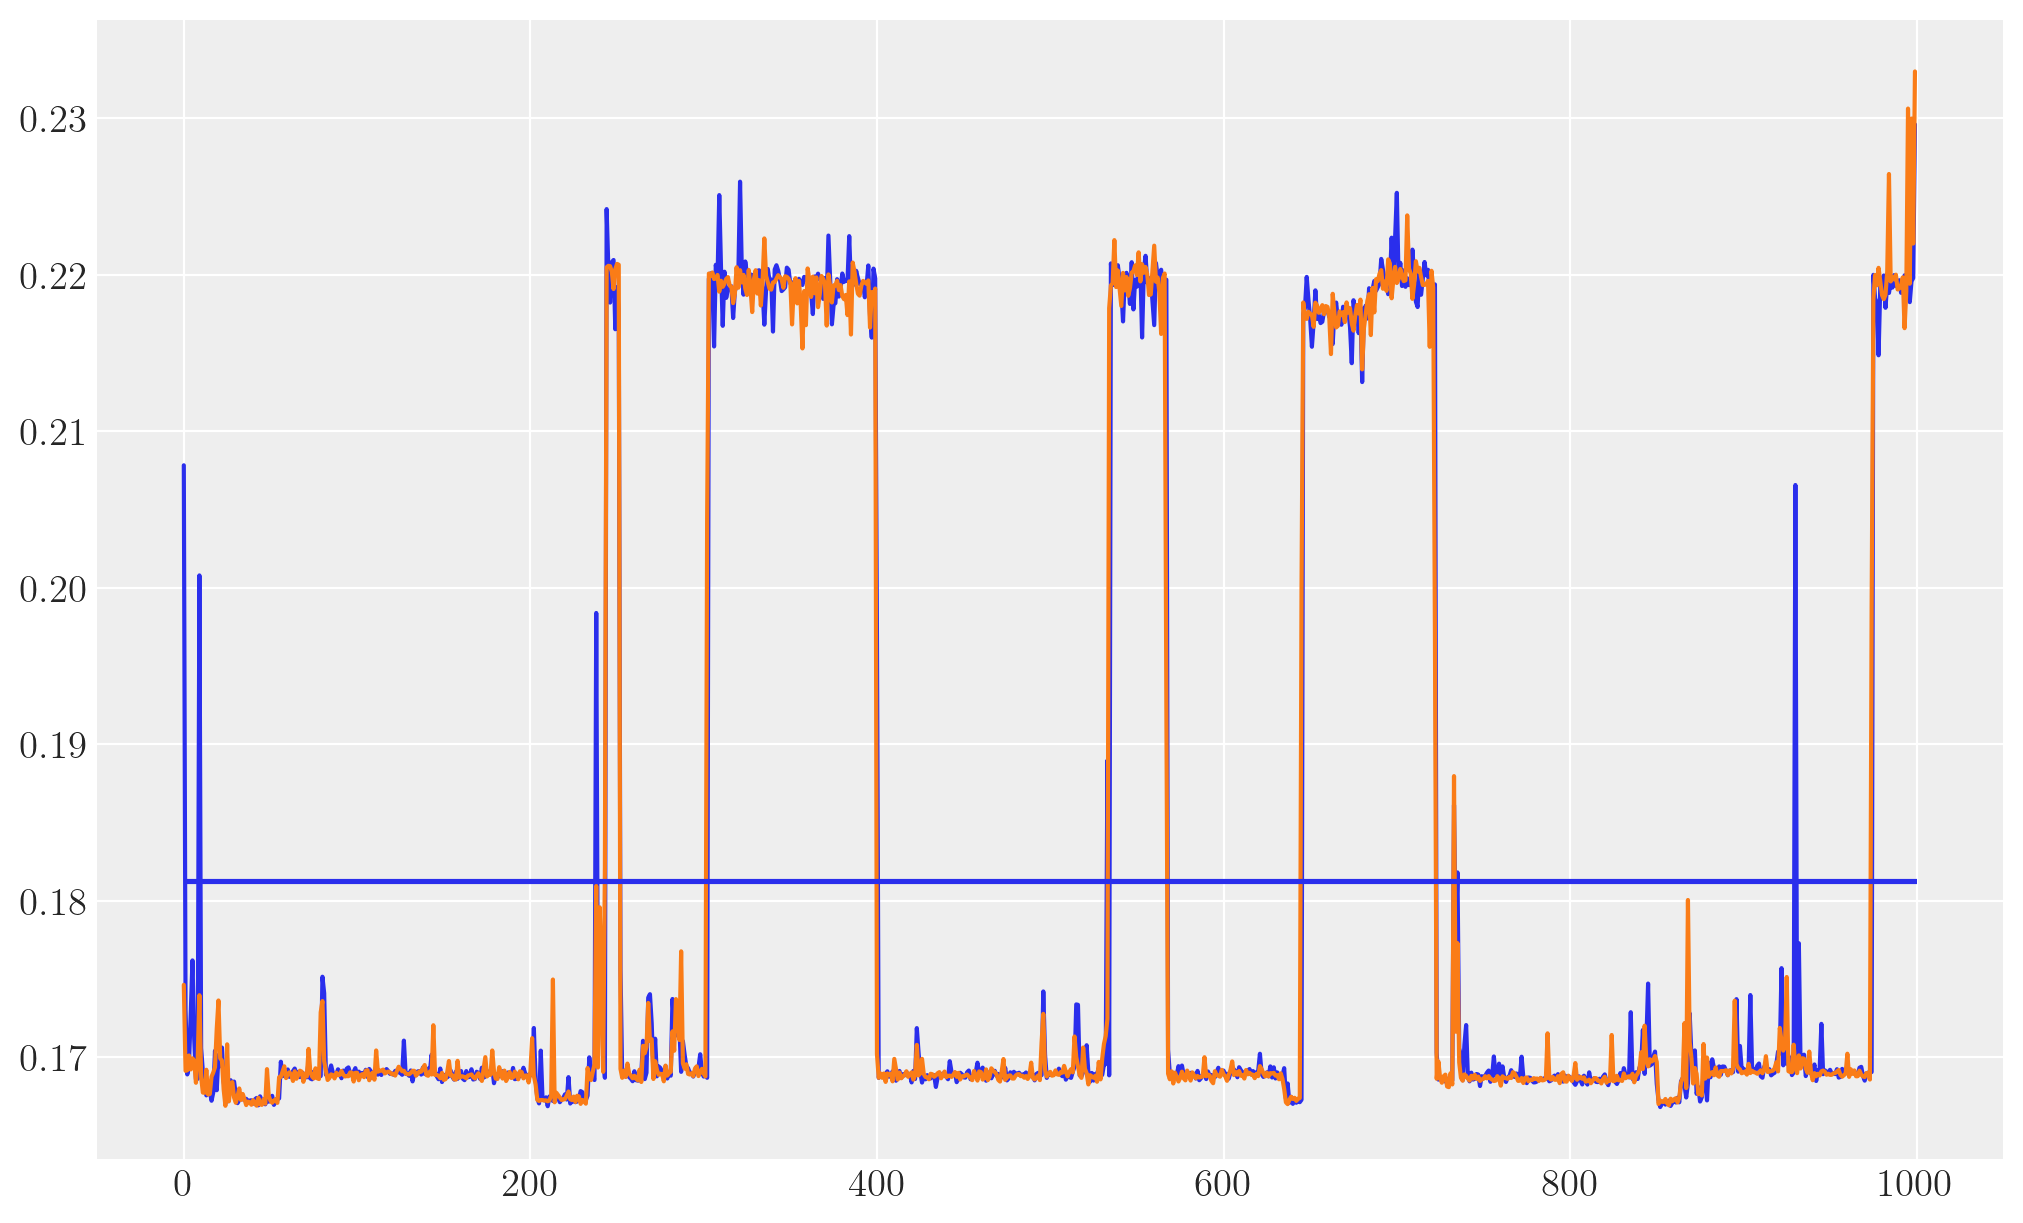

In [89]:
plt.figure(figsize = (10, 6))
plt.plot(model)
plt.plot(model2)
plt.hlines(xmin = 0, xmax = 1000, y = model.mean())
plt.hlines(xmin = 0, xmax = 1000, y = model2.mean())

In [72]:
0.00432062498293817 seconds
0.0023027079878374934 seconds

**********
0.005409625009633601 seconds
0.004211000050418079 seconds

SyntaxError: invalid syntax (170170084.py, line 1)

In [73]:
from time import perf_counter

In [98]:
t1 = perf_counter()
np.log(2)
t2 = perf_counter()
print(f"Run1: {t2 - t1} seconds")

Run1: 5.704199429601431e-05 seconds


In [94]:
model = pm.Model()
with model:
    

SyntaxError: incomplete input (3446488250.py, line 3)